<a href="https://colab.research.google.com/github/Jiayi1827/STAT-430/blob/main/HW6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Select univariate time series data. It could be from real data, or from existing package from R/Python. You may select the one with length >100. Show the time series plot of your data. Show the visual representation of your data. Consider last 10 observations as test data. Using deep learning method (of your choice), train your model/. Show the performance of your model using the test data and error metric.

The dataset is from an airplane company, including the number of passengers of each month from January 1949 to December 1960 (144 observations in total). The number of international airline passengers is in units of 1,000.

Data scorce: https://www.kaggle.com/datasets/rakannimer/air-passengers

Reference: https://www.youtube.com/watch?v=97bZKO6cJfg

In [77]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing

from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.preprocessing import MinMaxScaler

from operator import itemgetter
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from keras.models import load_model
import time

In [79]:
df=pd.read_csv('/content/drive/MyDrive/STAT 430 Time Series/HW6/AirPassengers.csv')

Data visualization

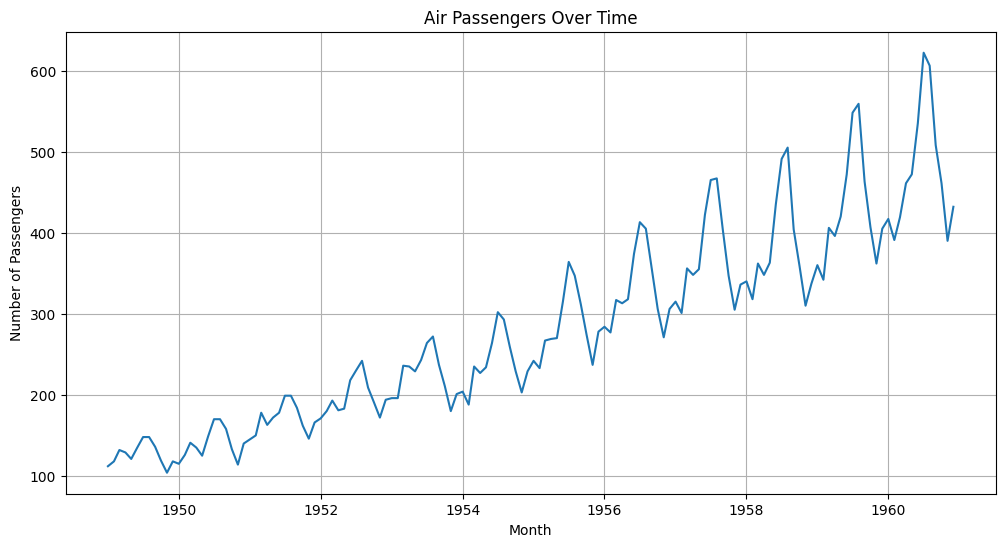

In [80]:
# Convert the 'Month' column to a datetime type
df['Month'] = pd.to_datetime(df['Month'])

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(df['Month'], df['#Passengers'])
plt.title('Air Passengers Over Time')
plt.xlabel('Month')
plt.ylabel('Number of Passengers')
plt.grid(True)
plt.show()


In [81]:
scaler = MinMaxScaler(feature_range=(0, 1))

# Reshape (as scaler expects 2D array)
passenger = df['#Passengers'].values.reshape(-1, 1)

# Apply the scaler to data
scaled_passenger = scaler.fit_transform(passenger)

df['Scaled_Passengers'] = scaled_passenger

df

,Month,#Passengers,Scaled_Passengers
0,1949-01-01,112,0.015444
1,1949-02-01,118,0.027027
2,1949-03-01,132,0.054054
3,1949-04-01,129,0.048263
4,1949-05-01,121,0.032819
...,...,...,...
139,1960-08-01,606,0.969112
140,1960-09-01,508,0.779923
141,1960-10-01,461,0.689189
142,1960-11-01,390,0.552124


Prepare the data

In [82]:
# Consider last 10 observations as test data
training = df['Scaled_Passengers'][:-10].values
testing = df['Scaled_Passengers'][-10:].values


def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 1  # Here I look back 1 step in history

trainX, trainY = create_dataset(training.reshape(-1, 1), look_back)
testX, testY = create_dataset(testing.reshape(-1, 1), look_back)

# Reshape input to be [samples, time steps, features] for LSTM
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))


LSTM model

In [91]:
# Define a single LSTM model
model = Sequential()
model.add(LSTM(64, input_shape=(None, look_back)))
model.add(Dense(32))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

# Training
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

# Predicting
train_predict = model.predict(trainX)
test_predict = model.predict(testX)


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_11 (LSTM)              (None, 64)                16896     
                                                                 
 dense_17 (Dense)            (None, 32)                2080      
                                                                 
 dense_18 (Dense)            (None, 1)                 33        
                                                                 
Total params: 19009 (74.25 KB)
Trainable params: 19009 (74.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
133/133 - 2s - loss: 0.0269 - 2s/epoch - 18ms/step
Epoch 2/100
133/133 - 1s - loss: 0.0047 - 799ms/epoch - 6ms/step
Epoch 3/100
133/133 - 1s - loss: 0.0041 - 884ms/epoch - 7ms/step
Epoch 4/100
133/133 - 1s - loss: 0.0043 - 1s/epoch - 8ms/step
Epoch 5/100
133/133 - 1s -

In [92]:
mse = mean_squared_error(testY, test_predict)
rmse = np.sqrt(mse)
mae = mean_absolute_error(testY, test_predict)

print(f"Test MSE: {mse:.5f}")
print(f"Test RMSE: {rmse:.5f}")
print(f"Test MAE: {mae:.5f}")

Test MSE: 0.01708
Test RMSE: 0.13069
Test MAE: 0.11150


In [85]:
# Invert predictions to original scale
train_predict = scaler.inverse_transform(train_predict)
trainY_original = scaler.inverse_transform([trainY])
test_predict = scaler.inverse_transform(test_predict)
testY_original = scaler.inverse_transform([testY])

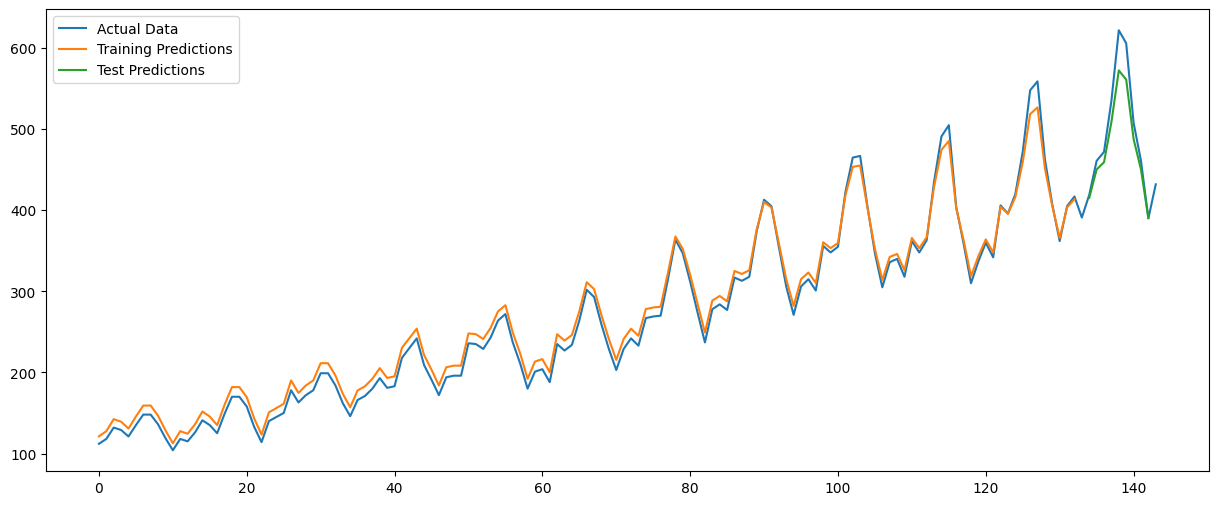

In [86]:
# Shift train predictions for plotting
train_predict_plot = np.empty_like(df['Scaled_Passengers'])
train_predict_plot[:] = np.nan

# Move the training predictions one step back
train_predict_plot[look_back-1:len(train_predict)+look_back-1] = train_predict[:,0]



# Shift test predictions for plotting
test_predict_plot = np.empty_like(df['Scaled_Passengers'])
test_predict_plot[:] = np.nan

# Move the test predictions one step back
test_predict_plot[-len(test_predict)-1:-1] = test_predict[:,0]


# Plot baseline and predictions
plt.figure(figsize=(15, 6))
plt.plot(scaler.inverse_transform(df['Scaled_Passengers'].values.reshape(-1, 1)), label='Actual Data')
plt.plot(train_predict_plot, label='Training Predictions')
plt.plot(test_predict_plot, label='Test Predictions')
plt.legend()
plt.show()
